In [202]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Demodulation
7. Analysis

Date created: 6/9/25
Author: Cole Delong
"""

'\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Demodulation\n7. Analysis\n\nDate created: 6/9/25\nAuthor: Cole Delong\n'

In [203]:
# Imports
import scipy
import numpy as np
import matplotlib.pyplot as plt

# Constants
SPS = int(10)                 # Large to see pulse shape well
N_BITS = 10**6
N_SYMBOLS = int(N_BITS/2)     # qpsk: 2 bits/sample
SNR_DB = 0


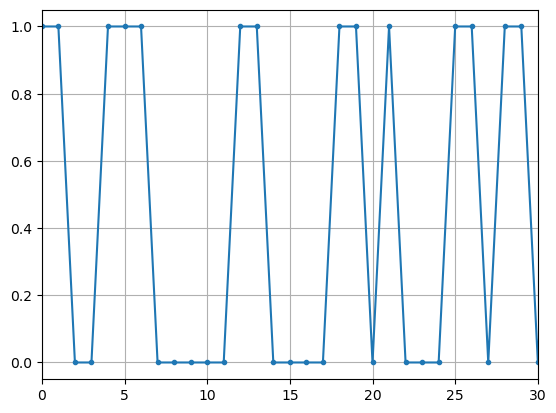

In [204]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
bit_pairs = bits_tx.reshape(-1, 2)

plt.plot(bits_tx, '.-')
plt.grid(True)
plt.xlim([0, 30])
plt.show()

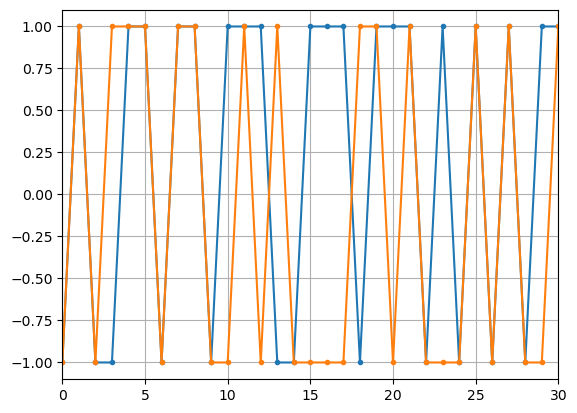

In [205]:
### QPSK modulation ###
bits_to_sym_map = {
    (0, 0):  1 + 1j,
    (0, 1):  1 - 1j,
    (1, 1): -1 - 1j,
    (1, 0): -1 + 1j,
}

sym_tx = np.array([bits_to_sym_map[tuple(pair)] for pair in bit_pairs])

plt.plot(sym_tx.real, '.-')
plt.plot(sym_tx.imag, '.-')
plt.grid(True)
plt.xlim([0, 30])
plt.show()


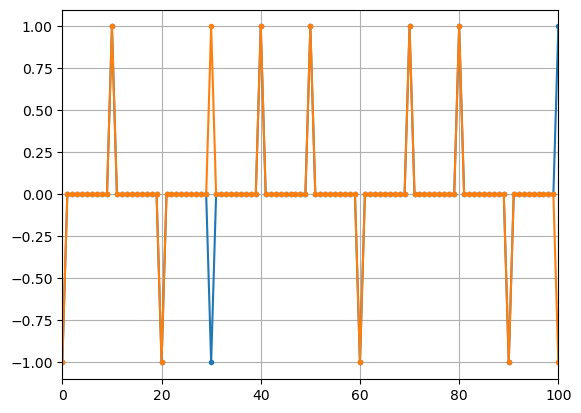

In [206]:
### Pulse filtering ###

# Interpolate by factor of SPS
sym_interp = np.zeros(N_SYMBOLS * SPS, dtype=complex)
for i, sym in enumerate(sym_tx):
    sym_interp[i*SPS] = sym

plt.plot(sym_interp.real, '.-')
plt.plot(sym_interp.imag, '.-')
plt.grid(True)
plt.xlim([0, 100])
plt.show()


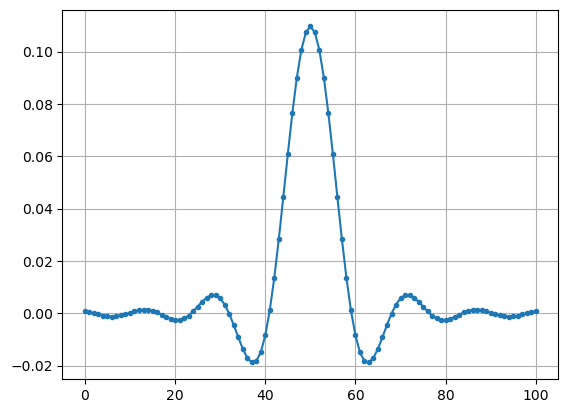

In [207]:
# Create root-raised cosine filter
num_taps = 101
beta = 0.35
Ts = SPS

h_rrc = np.zeros(num_taps, dtype=complex)
t_vec = np.arange(num_taps)  - (num_taps-1)//2 # -50, -49, ..., 49, 50
for i, t in enumerate(t_vec):  
    # Piecewise definition from https://en.wikipedia.org/wiki/Root-raised-cosine_filter
    
    # t = 0:
    if t == 0:
        h_rrc[i] = 1/Ts * (1 + beta*(4/np.pi - 1))
        continue

    # t = Ts/(4*beta): 
    if abs(t) == Ts/(4*beta):
        h_rrc[i] = beta/(Ts*np.sqrt(2)) * ( (1 + 2/np.pi)*np.sin(np.pi/(4*beta)) + \
                                       (1 - 2/np.pi)*np.cos(np.pi/(4*beta)) )
        continue

    # otherwise
    h_rrc[i] = 1/Ts * (np.sin(np.pi*(t/Ts)*(1-beta)) + 4*beta*(t/Ts)*np.cos(np.pi*(t/Ts)*(1+beta))) / \
                  (np.pi*(t/Ts)*(1 - (4*beta*(t/Ts))**2))

plt.plot(h.real, '.-')
plt.grid(True)
plt.show()

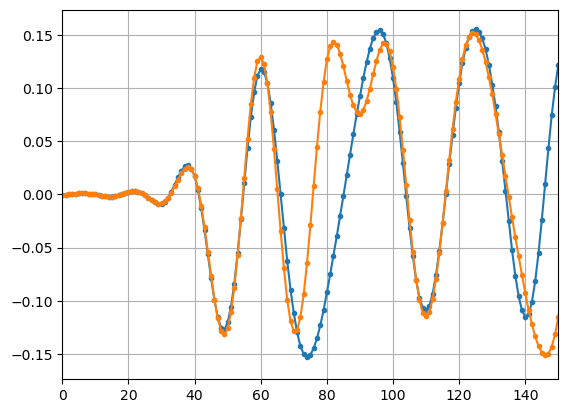

In [208]:
# Convolve signal with RRC filter
sig_rrc = np.convolve(sym_interp, h_rrc)

plt.plot(sig_rrc.real, '.-')
plt.plot(sig_rrc.imag, '.-')
plt.grid(True)
plt.xlim([0, 150])
plt.show()

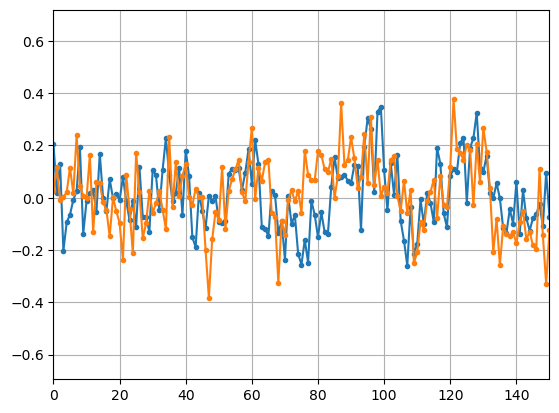

In [209]:
### Channel ###

signal_power = np.mean(abs(sig_rrc) ** 2)
noise_power = signal_power / (10**(SNR_DB / 10))
awgn = np.sqrt(noise_power / 2) * (np.random.normal(0, 1, len(sig_rrc)) + 1j * np.random.normal(0, 1, len(sig_rrc)))
sig_rx = sig_rrc + awgn

plt.plot(sig_rx.real, '.-')
plt.plot(sig_rx.imag, '.-')
plt.grid(True)
plt.xlim([0, 150])
plt.show()

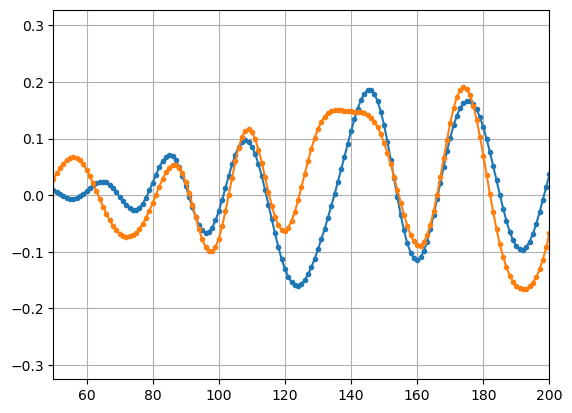

In [210]:
### Matched filter ###
sig_matched = np.convolve(sig_rx, h_rrc)

plt.plot(sig_matched.real, '.-')
plt.plot(sig_matched.imag, '.-')
plt.grid(True)
plt.xlim([50, 200])
plt.show()

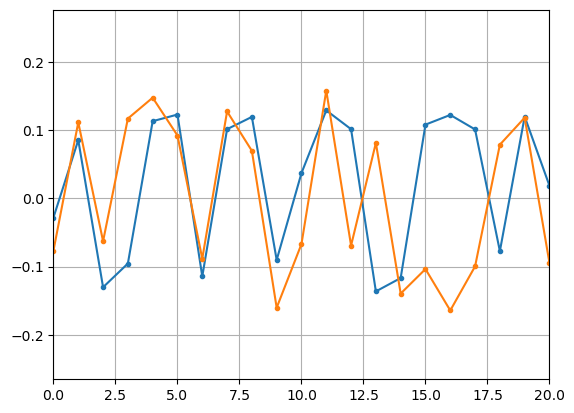

In [211]:
### Demodulation ###

# Remove extra shit from convolutions
sig_matched = sig_matched[100:-100]

# Decimate to 1 sps
sig_dec = np.empty(len(sig_matched) // 10, dtype=complex)
for i, samp in enumerate(sig_matched):
    if i % 10 == 0:
        sig_dec[i//10] = samp

plt.plot(sig_dec.real, '.-')
plt.plot(sig_dec.imag, '.-')
plt.grid(True)
plt.xlim([0, 20])
plt.show()

In [218]:
# Looks good! 

# Decide on each symbol
sym_rx = np.empty(len(sig_dec), dtype=complex)
for i, sym in enumerate(sig_dec):
    if sym.real > 0 and sym.imag > 0: sym_rx[i] =  1 + 1j
    if sym.real > 0 and sym.imag < 0: sym_rx[i] =  1 - 1j
    if sym.real < 0 and sym.imag < 0: sym_rx[i] = -1 - 1j
    if sym.real < 0 and sym.imag > 0: sym_rx[i] = -1 + 1j

# Map each symbol to bits
sym_to_bits_map = {
    (1+1j) : [0, 0],
    (1-1j) : [0, 1],
    (-1-1j): [1, 1],
    (-1+1j): [1, 0],
}

bits_rx = np.concatenate([sym_to_bits_map[sym] for sym in sym_rx])

print(f"BER: {np.mean(bits_tx != bits_rx)}")

BER: 0.000756


In [ ]:
#TODO: Graph BER vs SNR